In [1]:
import math
import random

import gymnasium as gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal, Categorical
from IPython.display import clear_output
import matplotlib.pyplot as plt

from collections import deque

In [2]:
env_name = 'CartPole-v1'
env = gym.make(env_name, render_mode='human')

In [3]:
class QNet(nn.Module):
    def __init__(self, action_num=2, hidden_size=256):
        super(QNet, self).__init__()
        self.fc1 = nn.Linear(4, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_num)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        q_values = self.fc2(x)
        return q_values

In [4]:
class ReplayBuffer:
    def __init__(self, data_names, buffer_size, mini_batch_size):
        self.data_keys = data_names
        self.data_dict = {}
        self.buffer_size = buffer_size
        self.mini_batch_size = mini_batch_size
        self.reset()

    def reset(self):
        # Create a deque for each data type with set max length
        for name in self.data_keys:
            self.data_dict[name] = deque(maxlen=self.buffer_size)

    def buffer_full(self):
        return len(self.data_dict[self.data_keys[0]]) == self.buffer_size

    def data_log(self, data_name, data):
        # split tensor along batch into a list of individual datapoints
        data = data.cpu().split(1)
        
        # Extend the deque for data type, deque will handle popping old data to maintain buffer size
        self.data_dict[data_name].extend(data)

    def __iter__(self):
        batch_size = len(self.data_dict[self.data_keys[0]])
        batch_size = batch_size - batch_size % self.mini_batch_size

        ids = np.random.permutation(batch_size)
        ids = np.split(ids, batch_size // self.mini_batch_size)
        for i in range(len(ids)):
            batch_dict = {}
            for name in self.data_keys:
                c = [self.data_dict[name][j] for j in ids[i]]
                batch_dict[name] = torch.cat(c)
            batch_dict["batch_size"] = len(ids[i])
            yield batch_dict

    def __len__(self):
        return len(self.data_dict[self.data_keys[0]])

In [5]:
q_net = QNet()

In [6]:
def test_agent():
    truncated = False
    total_reward = 0
    observation = torch.FloatTensor(env.reset()[0]).unsqueeze(0)

    with torch.no_grad():
        while not truncated:
            q_values = q_net(observation)
            # print
            # print(f"q_values: {q_values.cpu().numpy()}")
            action = q_values.argmax().cpu().item()
            # print
            # print(f"action: {action}")
            observation, reward, _, truncated, info = env.step(action)
            observation = torch.FloatTensor(observation).unsqueeze(0)
            total_reward += reward
            
    return total_reward

In [7]:
buffer_size = 2000
mini_batch_size = 32
gamma = 0.99
lr = 1e-2

optimizer = optim.Adam(q_net.parameters(), lr=lr)
data_names = ["states", "next_states", "actions", "rewards", "masks"]
replay_buffer = ReplayBuffer(data_names, buffer_size, mini_batch_size)

In [8]:
def dqn_update():
    for data_batch in replay_buffer:
        next_q_values = q_net(data_batch["next_states"]).detach()
        q_values = q_net(data_batch["states"])
        
        index_q_values = q_values.gather(1, data_batch["actions"])
        max_next_q_values = next_q_values.max(1)[0].unsqueeze(1)

        expected_q_value = data_batch["rewards"] + gamma * max_next_q_values * data_batch["masks"]

        q_loss = (index_q_values - expected_q_value).pow(2).mean()

        optimizer.zero_grad()
        q_loss.backward()
        optimizer.step()

In [9]:
max_steps = 150000
rollouts = 0
step = 0
initial_epsilon = 1
epsilon = initial_epsilon
score_logger = []

data_names = ["states", "next_states", "actions", "rewards", "masks"]

In [10]:
# print(env.reset()[0])
# print(torch.tensor(env.reset()[0]))
# print(torch.FloatTensor(env.reset()[0]))

In [11]:
while step < max_steps:
    # observation =  torch.FloatTensor(env.reset()).unsqueeze(0)
    observation =  torch.FloatTensor(env.reset()[0]).unsqueeze(0)
    turncated = False
    
    states = []
    rewards = []
    actions = []
    masks = []
    render = []

    while not turncated:
        states.append(observation)

        if random.random() > epsilon:
            q_values = q_net(observation)
            action = q_values.argmax().reshape(-1, 1)
        else:
            action = torch.LongTensor([env.action_space.sample()]).reshape(-1, 1)
                
        observation, reward, _, turncated, info = env.step(action.cpu().item())
        # ###############
        # if step % 100 == 0:
        #     render.append(env.render())
        # ###############
        reward = torch.FloatTensor([reward]).unsqueeze(0)
        
        rewards.append(reward)
        actions.append(action)
        masks.append(torch.FloatTensor([1 - turncated]).unsqueeze(0))
        
        observation = torch.FloatTensor(observation).unsqueeze(0)
        step += 1
        
    states.append(observation)
    #
    # print(f"state: {states}")
    # print(f"reward: {rewards}")
    # print(f"action: {actions}")
    # print(f"mask: {masks}")
    #
    replay_buffer.data_log("states", torch.cat(states[:-1]))
    replay_buffer.data_log("next_states", torch.cat(states[1:]))
    replay_buffer.data_log("rewards", torch.cat(rewards))
    replay_buffer.data_log("actions", torch.cat(actions))
    replay_buffer.data_log("masks", torch.cat(masks))

    if replay_buffer.buffer_full():
        dqn_update()

        if rollouts % 2 == 0:
            new_lr = max(1e-4, ((max_steps - step)/max_steps) * lr)
            epsilon = max(0.2, ((max_steps - step)/max_steps) * initial_epsilon)
            
            optimizer.param_groups[0]["lr"] = new_lr

            score_logger.append(np.mean([test_agent() for _ in range(10)]))
            clear_output(True)
            # plt.plot(score_logger)
            # plt.show()
    rollouts +=1

# env.close()

c:\Users\ltensuba\AppData\Local\miniconda3\envs\rl\lib\site-packages\gymnasium\envs\classic_control\cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


OverflowError: signed short integer is less than minimum

: 

In [ ]:
# env.close()

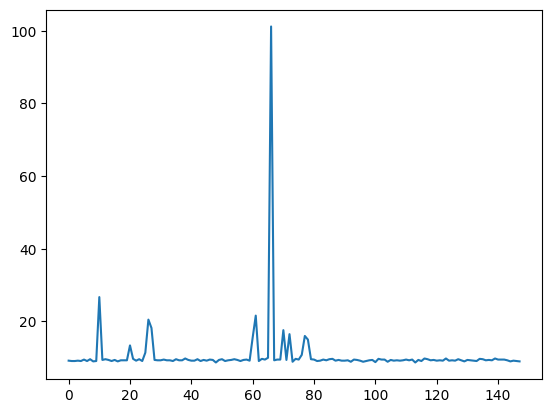

In [12]:
plt.plot(score_logger)

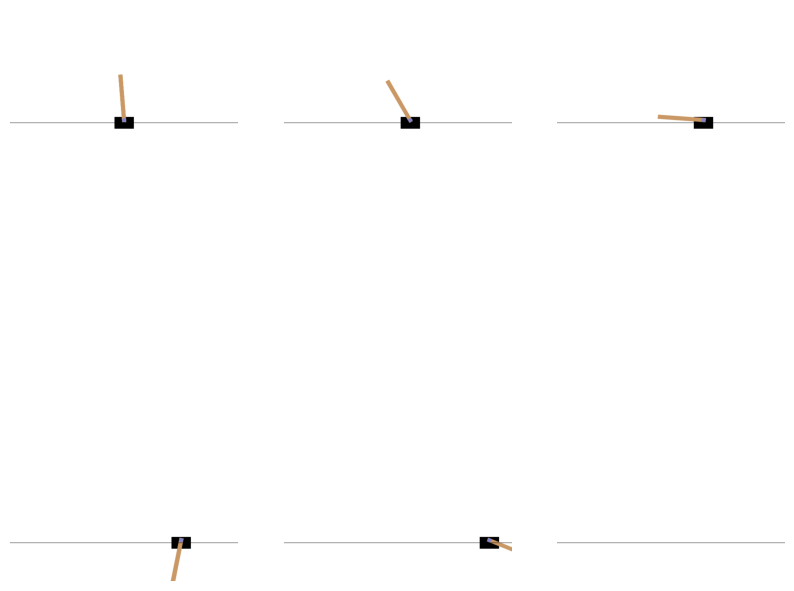

In [33]:
fig, axs = plt.subplots(2, 3, figsize=(10, 10))

for i, ax in enumerate(axs.flatten()):
    if i < len(render):
        ax.imshow(render[i])
        ax.axis('off')
    else:
        ax.axis('off')

plt.show()

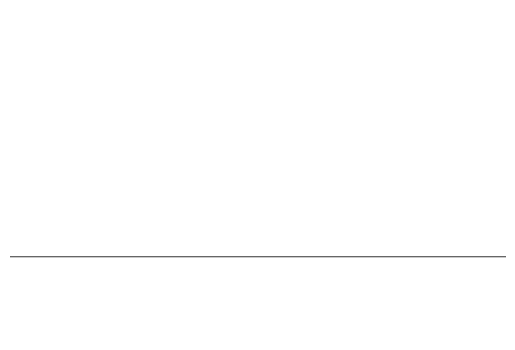

In [13]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure()  
plt.axis('off')  # Remove the axis
ims = [[plt.imshow(i , animated=True)] for i in render]
anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(anim.to_jshtml())

In [35]:
# env.close()

# New Approach

# discount factor
q(s{t}, a{t} ) = R{t} + γ * MAX-OVER-ACTION q( s(t+1), a)

In [3]:
import copy
from tqdm import tqdm
import torch
from torch import nn, optim
import gymnasium as gym
from collections import deque, namedtuple
from time import sleep
import numpy as np
import random
from itertools import count


In [4]:
class DQN_Agent:
    
    def __init__(self, seed, layer_sizes, lr, sync_freq, exp_replay_size):
        torch.manual_seed(seed)
        self.q_net = self.build_nn(layer_sizes)
        self.target_net = copy.deepcopy(self.q_net)
        # self.q_net
        # self.target_net
        self.loss_fn = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=lr)
        
        self.network_sync_freq = sync_freq
        self.network_sync_counter = 0
        self.gamma = torch.tensor(0.95).float()
        self.experience_replay = deque(maxlen = exp_replay_size)  
        
    def build_nn(self, layer_sizes):
        assert len(layer_sizes) > 1
        layers = []
        for index in range(len(layer_sizes)-1):
            linear = nn.Linear(layer_sizes[index], layer_sizes[index+1])
            act =    nn.Tanh() if index < len(layer_sizes)-2 else nn.Identity()
            layers += (linear,act)
        return nn.Sequential(*layers)
    
    def get_action(self, state, action_space_len, epsilon):
        with torch.no_grad():
            Qp = self.q_net(torch.from_numpy(state).float())
        Q,A = torch.max(Qp, axis=0)
        A = A if torch.rand(1,).item() > epsilon else torch.randint(0,action_space_len,(1,))
        return A
    
    def get_q_next(self, state):
        with torch.no_grad():
            qp = self.target_net(state)
        q,_ = torch.max(qp, axis=1)    
        return q
    
    def collect_experience(self, experience):
        self.experience_replay.append(experience)
        return

    def sample_from_experience(self, sample_size):
        if(len(self.experience_replay) < sample_size):
            sample_size = len(self.experience_replay)   
        sample = random.sample(self.experience_replay, sample_size)

        # print(sample[0][1], sample[0][2], sample[0][3])
        s = torch.tensor([exp[0][0] for exp in sample], dtype=torch.float32)
        a = torch.tensor([exp[1] for exp in sample], dtype=torch.float32)
        rn = torch.tensor([exp[2] for exp in sample], dtype=torch.float32)
        sn = torch.tensor([exp[3] for exp in sample], dtype=torch.float32)   
        return s, a, rn, sn

    
    def train(self, batch_size ):
        s, a, rn, sn = self.sample_from_experience( sample_size = batch_size)
        if(self.network_sync_counter == self.network_sync_freq):
            self.target_net.load_state_dict(self.q_net.state_dict())
            self.network_sync_counter = 0
        
        # predict expected return of current state using main network
        qp = self.q_net(s)
        pred_return, _ = torch.max(qp, axis=1)
        
        # get target return using target network
        q_next = self.get_q_next(sn)
        target_return = rn + self.gamma * q_next
        
        loss = self.loss_fn(pred_return, target_return)
        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        self.optimizer.step()
        
        self.network_sync_counter += 1       
        return loss.item()

In [5]:
env = gym.make('CartPole-v1', render_mode = "human")
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
# print(f"output_dim: {output_dim}")
exp_replay_size = 256
agent = DQN_Agent(seed = 1423, layer_sizes = [input_dim, 64, output_dim], lr = 1e-3, sync_freq = 5, exp_replay_size = exp_replay_size)

# initiliaze experiance replay      
index = 0
for i in range(exp_replay_size):
    obs = env.reset()
    turncated = False
    new_obs = obs[0]
    # new_obs = torch.tensor(obs[0], dtype=torch.float32).unsqueeze(0)
    # while(turncated != True):
    for t in count():
        A = agent.get_action(new_obs, env.action_space.n, epsilon=1)
        obs_next, reward, terminated, turncated, _ = env.step(A.item())
        
        agent.collect_experience([obs, A.item(), reward, obs_next])
        new_obs = obs_next
        index += 1
        if( index > exp_replay_size ):
            break
            
# Main training loop
losses_list, reward_list, episode_len_list, epsilon_list  = [], [], [], []
index = 128
n_episodes = 10000
epsilon = 1

for i in tqdm(range(n_episodes)):
    obs, turncated, losses, ep_len, rew = env.reset(), False, 0, 0, 0
    new_obs = obs[0]
    # new_obs = torch.tensor(obs[0], dtype=torch.float32).unsqueeze(0)
    # while(turncated != True):
    for t in count():
        ep_len += 1 
        A = agent.get_action(new_obs, env.action_space.n, epsilon)
        obs_next, reward, terminated, turncated, _ = env.step(A.item())
        agent.collect_experience([obs, A.item(), reward, obs_next])
       
        new_obs = obs_next
        rew  += reward
        index += 1
        
        if(index > 128):
            index = 0
            for j in range(4):
                loss = agent.train(batch_size=16)
                losses += loss
        if turncated or terminated:
            break
          
    if epsilon > 0.05 :
        epsilon -= (1 / 5000)
    
    losses_list.append(losses/ep_len), reward_list.append(rew), episode_len_list.append(ep_len), epsilon_list.append(epsilon)

c:\Users\ltensuba\AppData\Local\miniconda3\envs\rl\lib\site-packages\gymnasium\envs\classic_control\cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(
  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\ltensuba\AppData\Local\Temp\ipykernel_8564\2615867534.py:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  s = torch.tensor([exp[0][0] for exp in sample], dtype=torch.float32)
  0%|          | 14/10000 [02:34<30:38:19, 11.05s/it]


KeyboardInterrupt: 

In [25]:
# env = gym.make('CartPole-v1', render_mode = 'rgb_array_list')
# # env = gym.wrappers.Monitor(env, "record_dir")
# for i in tqdm(range(2)):
#     obs, turncated, rew = env.reset(), False, 0
#     new_obs = obs[0]
#     while (turncated != True) :
#         A =  agent.get_action(new_obs, env.action_space.n, epsilon = 0)
#         obs, reward, _, turncated, info = env.step(A.item())
#         new_obs = obs
#         rew += reward
#         sleep(0.01)
#         env.render()  
#     print("episode : {}, reward : {}".format(i,rew))

  0%|          | 0/2 [00:00<?, ?it/s]c:\Users\ltensuba\AppData\Local\miniconda3\envs\rl\lib\site-packages\gymnasium\envs\classic_control\cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(
  0%|          | 0/2 [00:05<?, ?it/s]


OverflowError: signed short integer is less than minimum

: 

In [1]:
3 + 3

6

13it [00:00, 25.25it/s]

Complete


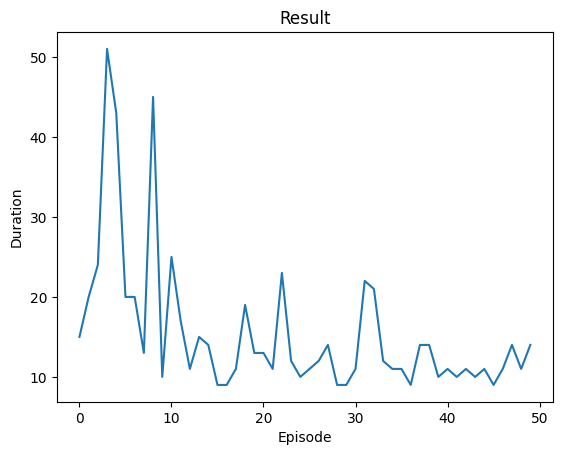

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

: 

In [4]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1", render_mode = "human")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    

class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)
    

# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()



if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in tqdm(range(num_episodes)):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in tqdm(count()):
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            # plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()